In [2]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c, G, k_B, m_e, M_sun
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
%matplotlib widget

# import agnpy classes
import agnpy
from agnpy.emission_regions import Blob
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import RingDustTorus, SSDisk
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed

load_mpl_rc()

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)


In [3]:
class AgnpyEC(model.RegriddableModel1D):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs.
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters
    whose range is expected to cover several orders of magnitudes (normalisation,
    gammas, size and magnetic field of the blob).
    """

    def __init__(self, name="ec"):
        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p1 = model.Parameter(name, "p1", 2.1, min=-2.0, max=5.0)
        self.p2 = model.Parameter(name, "p2", 3.1, min=-2.0, max=5.0)
        self.log10_gamma_b = model.Parameter(name, "log10_gamma_b", 3, min=1, max=6)
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = model.Parameter(name, "t_var", 600, min=10, max=np.pi * 1e7, units="s")
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log10_r = model.Parameter(name, "log10_r", 17.0, min=16.0, max=20.0)
        # disk parameters
        self.log10_L_disk = model.Parameter(name, "log10_L_disk", 45.0, min=42.0, max=48.0)
        self.log10_M_BH = model.Parameter(name, "log10_M_BH", 42, min=32, max=45)
        self.m_dot = model.Parameter(name, "m_dot", 1e26, min=1e24, max=1e30, units="g s-1")
        self.R_in = model.Parameter(name, "R_in", 1e14, min=1e12, max=1e16, units="cm")
        self.R_out = model.Parameter(name, "R_out", 1e17, min=1e12, max=1e19, units="cm")
        # DT parameters
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(name, "T_dt", 1.0e3, min=1.0e2, max=1.0e4, units="K")
        self.R_dt = model.Parameter(name, "R_dt", 2.5e18, min=1.0e17, max=1.0e19, units="cm")

        model.RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p1,
                self.p2,
                self.log10_gamma_b,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
                self.mu_s,
                self.log10_r,
                self.log10_L_disk,
                self.log10_M_BH,
                self.m_dot,
                self.R_in,
                self.R_out,
                self.xi_dt,
                self.T_dt,
                self.R_dt,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p1,
            p2,
            log10_gamma_b,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
            mu_s,
            log10_r,
            log10_L_disk,
            log10_M_BH,
            m_dot,
            R_in,
            R_out,
            xi_dt,
            T_dt,
            R_dt,
        ) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm
        r = 10 ** log10_r * u.cm
        d_L *= u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        m_dot *= u.Unit("g s-1")
        R_in *= u.cm
        R_out *= u.cm
        R_dt *= u.cm
        T_dt *= u.K
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            x,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )
        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(x, z, L_disk, M_BH, m_dot, R_in, R_out, d_L)
        
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(x, z, xi_dt * L_disk, T_dt, R_dt, d_L)
    
        return sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt


In [4]:
# read data
source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/PKS1510-089_example.csv') 

freq = source['freq'].values
flux = source['flux'].values
flux_err = source['flux_err'].values
#######################################################################################################
### systematic errors
#######################################################################################################
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
### define energy ranges
nu_vhe = 2.42E25 # [Hz]
nu_he = 2.42E22 # [Hz]
nu_x_ray_max = 4.25E19 # [Hz]
nu_x_ray_min = 7.25E16 # [Hz]
vhe_gamma = freq >= nu_vhe
he_gamma = (freq >= nu_he) * (freq  < nu_vhe)
x_ray = (freq  >= nu_x_ray_min) * (freq  < nu_x_ray_max)
uv_to_radio = freq  < nu_x_ray_min

### declare systematics
y_err_syst = np.zeros(len(freq ))
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = flux * y_err_syst

# define the data1D object containing it
sed = data.Data1D("sed", freq, flux, staterror = flux_err, syserror = y_err_syst)



In [5]:
#######################################################################################################
# declare a model
#######################################################################################################
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361                                     # redshift 
d_L = Distance(z=z).to("cm")                  # luminosity distance [cm]
# blob
Gamma = 20                                    # Lorentz factor 
delta_D = 25                                  # doppler factor δ
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))    # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta     # viewing angle
B = 0.35                                      # magnetic field sterength [G]
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")           # disk luminosity
M_BH = 5.71E7 * M_sun                         # black hole mass
eta = 1/12                                    # ?
m_dot = (L_disk / (eta * c ** 2)).to("g s-1") # accretion rate
R_g = ((G * M_BH) / c ** 2).to("cm")          # [cm]
R_in = 6 * R_g                                # [cm]
R_out = 10000 * R_g                           # [cm]
# DT
xi_dt = 0.6                                   # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3                                    # [K]
R_dt = 6.47 * 1e18                            # [cm]
# size and location of the emission region
t_var = 86400*0.5                             # varaibility timescale of emission region [sec]
r = 6e17                                      # size of emission region [cm]

# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z = z                                # redshift 
agnpy_ec.z.freeze()
agnpy_ec.d_L = d_L.cgs.value                  # luminosity distance [cm]
agnpy_ec.d_L.freeze()
# -- SS disk
agnpy_ec.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))  # disk luminosity
agnpy_ec.log10_L_disk.freeze()
agnpy_ec.log10_M_BH = np.log10(M_BH.to_value("g")) # black hole mass
agnpy_ec.log10_M_BH.freeze()
agnpy_ec.m_dot = m_dot.to_value("g s-1")      # accretion rate
agnpy_ec.m_dot.freeze()
agnpy_ec.R_in = R_in.to_value("cm")           # [cm]
agnpy_ec.R_in.freeze()
agnpy_ec.R_out = R_out.to_value("cm")         # [cm]
agnpy_ec.R_out.freeze()
# -- Dust Torus
agnpy_ec.xi_dt = xi_dt                        # fraction of disk luminosity reprocessed by the DT
agnpy_ec.xi_dt.freeze()
agnpy_ec.T_dt = T_dt                          # [K]
agnpy_ec.T_dt.freeze()
agnpy_ec.R_dt = R_dt                          # [cm]
agnpy_ec.R_dt.freeze() 
# - blob parameters
agnpy_ec.delta_D = delta_D                    # doppler factor δ
agnpy_ec.delta_D.freeze()
agnpy_ec.log10_B = np.log10(B)                # magnetic field sterength [G]
agnpy_ec.mu_s = mu_s                          # viewing angle
agnpy_ec.mu_s.freeze()
agnpy_ec.t_var = t_var                        # varaibility timescale of emission region [sec]
agnpy_ec.t_var.freeze()
agnpy_ec.log10_r = np.log10(r)                # size of emission region [cm]
agnpy_ec.log10_r.freeze()
# - EED
agnpy_ec.log10_k_e = np.log10(0.05)           # opacity [cm^-3]
agnpy_ec.p1 = 1.8                             # spectral index
agnpy_ec.p2 = 3.5                             # spectral index
agnpy_ec.log10_gamma_b = np.log10(500)        # lorentz break factor
agnpy_ec.log10_gamma_min = np.log10(1)        # minimum lorentz factor
agnpy_ec.log10_gamma_min.freeze()
agnpy_ec.log10_gamma_max = np.log10(3e4)      # minimum lorentz factor
agnpy_ec.log10_gamma_max.freeze()


-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 4311.24
Final fit statistic   = 220.031 at function evaluation 121
Data points           = 41
Degrees of freedom    = 36
Probability [Q-value] = 2.79673e-28
Reduced statistic     = 6.11196
Change in statistic   = 4091.21
   ec.log10_k_e   -2.16763     +/- 0.247793    
   ec.p1          1.9987       +/- 0.0623968   
   ec.p2          3.31197      +/- 0.0350999   
   ec.log10_gamma_b   3.0697       +/- 0.0815203   
   ec.log10_B     -0.429109    +/- 0.0177747   


Text(0.5, 1.0, 'PKS 1510-089 SED Fitting ($\\chi^2$ = 6.11)')

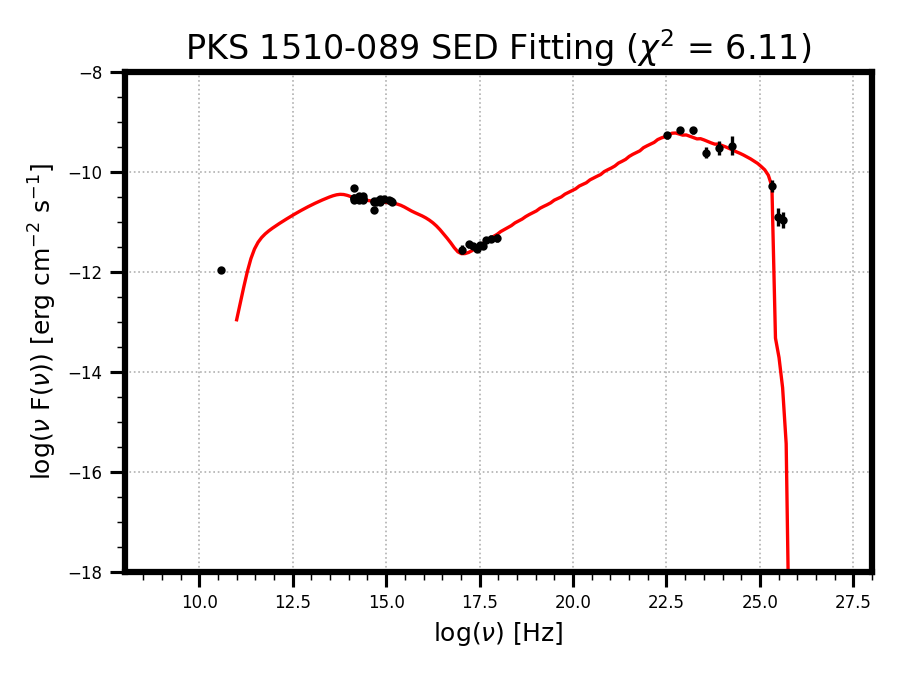

In [6]:
#######################################################################################################
### fit using the Levenberg-Marquardt optimiser
#######################################################################################################
fitter = Fit(sed, agnpy_ec, stat = Chi2(), method = LevMar())
fitter = Fit(sed, agnpy_ec, stat=Chi2(), method=LevMar())

# Set minimum and maximum frequency to proced model fit
min_x = 1.0E11
max_x = 1.0E30
sed.notice(min_x, max_x)

#######################################################################################################
### perform model fit
#######################################################################################################
result = fitter.fit()
print("-- fit succesful?", result.succeeded)
print(result.format())

#######################################################################################################
### plot model fit results!
#######################################################################################################
data_x = sed.x
data_y = sed.y
y_err_lin = sed.get_error()
data_y_err = 0.434*y_err_lin/data_y

fit_x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
fit_y = agnpy_ec(fit_x).to_value()

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

ax.plot(np.log10(fit_x), np.log10(fit_y), '-', color = 'red')
ax.errorbar(np.log10(data_x), np.log10(data_y), yerr = data_y_err, marker=".", color = "black", ecolor = "black", linestyle = '') 

ax.set_xlim (8, 28)
ax.set_ylim (-18, -8) 

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 12)
plt.yticks(fontsize = 8)
plt.grid(True)
figurename = 'PKS 1510-089 SED Fitting ($\\chi^2$ = %.2f)' %(float(result.rstat))
plt.title(figurename, fontsize = 16)



In [2]:
#######################################################################################################
### save SED file into csv form
#######################################################################################################
import pandas as pd

def ClearData():
    data = {
    'freq': [],
    'flux': [],
    'flux_err': []
      }
    return data

df = ClearData()

# read the 1D data
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv")
sed_table = Table.read(sed_path)

for i in range(0, len(sed_table)):
    df['freq'].append(sed_table[i][0]/4.13E-15) # eV to Hz
    df['flux'].append(sed_table[i][1])
    df['flux_err'].append(sed_table[i][2])

CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED code and data/PKS1510-089_example.csv'   
dff = pd.DataFrame(df)      
dff.to_csv(CSVfile, index = False)